# TV 正則化による色塗り

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$$\text{minimize}\ \sum_{i\in\mathcal{V}}d^2(u_i,f_i)+\lambda\sum_{i\in\mathcal{G}}\sum_{j\in\mathcal{N}^+}\varphi(d(u_i,u_j))\quad
\text{subject to}\ u_i\in S^{2}$$

In [2]:
import sys

sys.path += ['..', '../..']
from modules.total_variation.total_variation_sphere import TVonSphere

In [3]:
def normalize(img: np.ndarray) -> np.ndarray:
    res = img - np.min(img)
    res = res / np.max(res)
    return res

### 画像の読み込み

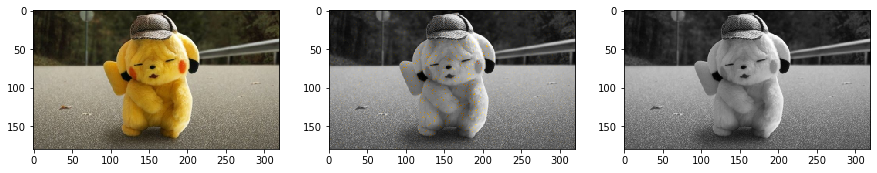

In [5]:
import cv2

img = cv2.cvtColor(cv2.imread('../../data/pikachu.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)

# 明度の情報
brightness = np.linalg.norm(img.astype(np.float32), axis=-1, keepdims=True)

# 5% の色情報
np.random.seed(0)
mask = np.random.rand(np.prod(img.shape[:2])).reshape(*img.shape[:2], 1)
mask = np.uint8(mask > 0.95)
defected = np.uint8(normalize(np.tile(brightness, 3)) * 255)
defected[mask[:,:,0]==1] = img[mask[:,:,0]==1]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.grid(False)
plt.subplot(1,3,2)
plt.imshow(defected)
plt.grid(False)
plt.subplot(1,3,3)
plt.imshow(brightness[:,:,0], cmap='gray')
plt.grid(False)
plt.show()

### Inpaint による色の初期化

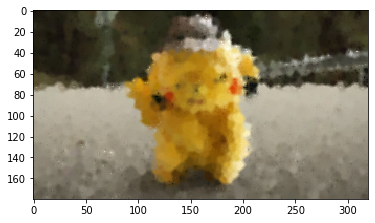

In [5]:
inpainted = cv2.inpaint(img, 255 - np.uint8(mask[:, :, 0] > 0) * 255, 3, cv2.INPAINT_TELEA)
plt.imshow(inpainted)

### TV 正則化

In [6]:
tv = TVonSphere(c=20.0, initial_step = .1, total_max_iter=50, max_iter=50, extended_output=True)
%prun X = tv.transform(img*mask, mask=mask)

100%|██████████| 50/50 [00:33<00:00,  1.48it/s]

### 実行結果
色情報

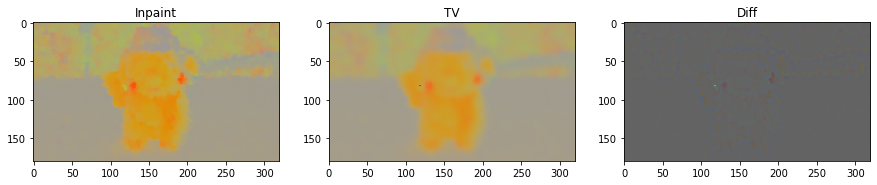

diff: 1.0193978217871975


In [7]:
initialized = tv._inpaint(img)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(normalize(initialized))
plt.title('Inpaint')
plt.subplot(1,3,2)
plt.imshow(normalize(X))
plt.title('TV')
plt.subplot(1,3,3)
plt.imshow(normalize(initialized - X))
plt.title('Diff')
plt.show()

print(f'diff: {np.max(np.abs(initialized - X))}')

画像の復元

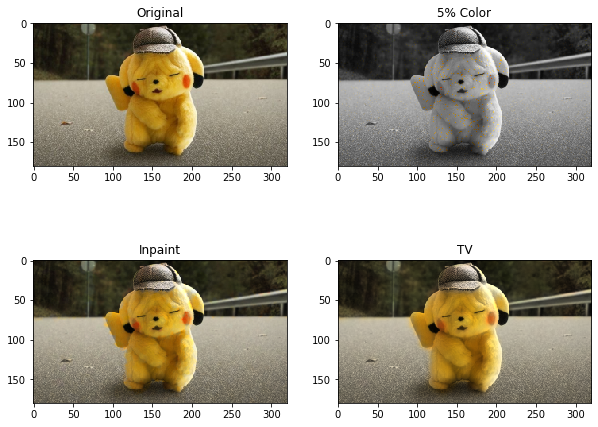

In [8]:
result = X * brightness
result = np.uint8(np.clip(result, 0, 255))
inpainted = initialized * brightness
inpainted = np.uint8(np.clip(inpainted, 0, 255))

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(defected)
plt.title('5% Color')
plt.subplot(2,2,3)
plt.imshow(inpainted)
plt.title('Inpaint')
plt.subplot(2,2,4)
plt.imshow(result)
plt.title('TV')
plt.show()

目的関数値

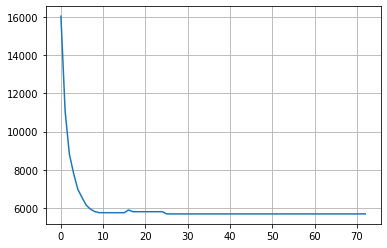

In [9]:
plt.plot(tv.f)
plt.grid()

In [13]:
X = np.arange(12).reshape(2,2,3)
Y = np.arange(1, 13).reshape(2,2,3)
np.dot(X, Y.transpose(1, 2, 0))

array([[[[  8,  26],
         [ 17,  35]],

        [[ 26,  98],
         [ 62, 134]]],


       [[[ 44, 170],
         [107, 233]],

        [[ 62, 242],
         [152, 332]]]])